# Databáze

TODO: zde bude motivace, popis, co jsou databáze, proč se na ně chceme napojovat... Že se používá jazyk SQL.

TODO: asi bych tu databázi filmů upravil, aby tam aspoň rok vydání toho filmu anebo hodnocení, aby se na tom daly dělat smysluplné agregace. Nebo použit jinou databázi? S filmy se pracovalo už na předchozí hodině, ale tam zas nebyli ti herci, aby se daly pěkně ukazovat ty joiny.

<br><br><br>

Obsah:

- Úvod do databází
- Úvod do relačních databází
- Úvod do SQL + Python a Pandas


## Úvod do databází

Doteď jste na kurzu zřejmě pracovali se **soubory** - odněkud soubor stáhli na svůj počítač, a tam ho zpracovali, a pak třeba zase výsledek někam nahráli. Tento postup ale nestačí, pokud s těmito daty potřebuje pracovat více lidí (nebo strojů) najednou a zároveň je i aktualizovat. To se řeší tak, že spustíte **databázový systém** (DBMS, [SŘBD](https://cs.wikipedia.org/wiki/Syst%C3%A9m_%C5%99%C3%ADzen%C3%AD_b%C3%A1ze_dat)), ten ta data u sebe spravuje (soubory na disku obsahující specializované datové struktury) a vy se na tento systém připojujete přes počítačovou síť. Nebo třeba používáte webovou aplikaci a ta je na tento databázový systém (databázi) připojena.

Např. e-shop bude pracovat s databází, ve které jsou uloženy informace o prodávaném zboží, rozdělení zboží do kategorií, objednávky, reklamace, registrovaní uživatelé... Takovou databázi můžeme označit za "transakční".

Vy jako datoví analytici, inženýři apod. se pravděpodobně budete chtít do takovéto databáze připojit a stáhnout si z ní část dat pro svou další práci. Nebo dokonce může být vaším úkolem vytvořit novou "analytickou" databázi, která obsahuje data v jiné podobě, např. prodávané zboží bez popisků, bez fotografií, ale zato se statistikami návštěvnosti a prodejnosti.

V těchto materiálech budeme pracovat s databází [SQLite](https://www.sqlite.org/). Ta je poněkud specifická tím, že je uložena v jednom souboru (s příponou `.sqlite` nebo `.db`), není to tedy samostatně běžící server, ke kterému byste se připojovali, jak je tomu u většiny databází. O to snadněji se ale s SQLite pracuje. I SQLite umožňuje pracovat s jednou databází (jedním souborem) z několika programů zároveň, narozdíl od např. CSV nebo XLS sobourů.

## Vlastnosti databází

Od databáze (resp. databázového systému) očekáváme několik vlastností:

- Že bude uchovávat data :) Ne, vážně - data musí zůstat beze ztráty uložena i v případě výpadku napájení, když dojde místo na disku...
- Práce s daty "z různých úhlů". Např. v e-shopu chceme jednou vypsat zboží podle kategorie, jindy podle stavu skladových zásob, jindy na základě full-textového vyhledávání..
- Podpora uživatelů, rolí, oprávnění a kontroly přístupu k datům, security.
- Rychlost, výkon, propustnost, latence
- Škálovatelnost - jak do velikosti (gigabajty, terabajty, petabajty), tak do počtu prováděných operací za sekundu
- ACID
  - Atomicity:
  - Consistency:
  - Isolation:
  - Durability:
  
Když se nad tím zamyslíte, jedná se o protichůdné požadavky. Tvůrci databázových systémů tak musí zvolit nějaký kompomis. Někdy lze databáze nakonfigurovat, zda má např. preferovat izolaci, nebo propustnost (viz [PostgreSQL Transaction Isolation](https://www.postgresql.org/docs/9.5/transaction-iso.html)). Žádná databáze není "nejlepší" a vhodná na všechno. Zrovna co se týče rozdílu mezi "transakční" a "analytickou" databází, tak často pro tyto oblasti jsou vhodné odlišné systémy a přístupy.
  

## Relační databáze

Jde o typickou, klasickou, nejčastěji používanou kategorii databázových systémů. Používají se od 70. let, existuje okolo nich široký ekosystém se spoustou nástrojů a také lidí, kteří s nimi umí pracovat.

Co [relační databáze](https://en.wikipedia.org/wiki/Relational_database) obsahuje:

- "databáze" (jeden databázový systém může spravovat několik databází)
  - uživatelé (users)
  - **tabulky**
    - **sloupce**
    - indexy
    - constraints
    - cizí klíče (foreign keys)
    - triggery
  - pohledy (views)
  - procedury
  - sekvence

Data se ukládají v podobě řádek a sloupců do jednotlivých tabulek:

| title                 | year | director_name   | director_birthdate |
|:----------------------|:-----|:----------------|:-------------------|
| Pelíšky               | 1999 | Jan Hřebejk     | 1967-06-27         |
| Forrest Gump          | 1994 | Robert Zemeckis | 1951-05-14         |
| Návrat do budoucnosti | 1985 | Robert Zemeckis | 1951-05-14         |

Každý řádek je označen svým unikátním identifikátorem, a duplicitní data se *normalizují*:

| movie_id | title                 | year | director_id |
|----------|:----------------------|:-----|:------------|
|        1 | Pelíšky               | 1999 | 1           |
|        2 | Forrest Gump          | 1994 | 2           |
|        3 | Návrat do budoucnosti | 1985 | 2           |

| director_id | name            | birthdate  |
|-------------|:----------------|------------|
|           1 | Jan Hřebejk     | 1967-06-27 |
|           2 | Robert Zemeckis | 1951-05-14 |

Vztah mezi režiséry a filmy je zde 1:N. Každý jeden režisér je provázán s několika filmy. Každý jeden film je provázán s jedním režisérem (a nebo žádným, pokud jeho director_id není vyplněno).

Co když chceme vyjádřit možnost, že jeden film může mít více než jednoho režiséra?

| movie_id | title                 | year | director_id |
|----------|:----------------------|:-----|:------------|
|        1 | Pelíšky               | 1999 | 1           |
|        2 | Forrest Gump          | 1994 | 2           |
|        3 | Návrat do budoucnosti | 1985 | 2           |

| director_id | name            | birthdate  |
|-------------|:----------------|------------|
|           1 | Jan Hřebejk     | 1967-06-27 |
|           2 | Robert Zemeckis | 1951-05-14 |
|           3 | Joe Smith       | 1950-01-01 |

| movie_id | director_id |
|----------|-------------|
| 1        | 1           |
| 2        | 2           |
| 3        | 2           |
| 3        | 3           | 



## SQL

SQL je jazyk, kterým komunikujeme s relační databází. Umí vyjádřit různé operace nad tabulkami - výběr sloupců, řádků, vztahy mezi více tabulkami, agregace hodnot z více řádků... (Nepřípomíná vám to něco? Pandas DataFrame? :) )

Příklad:

```
SELECT title, year FROM movies;

UPDATE directors SET birthdate = "1950-01-02" WHERE director_id = 3;
```

Dokonce i jiný software, než jsou relační databáze, rozumí SQL. Často právě analytické nástroje, data lakes, Amazon S3... Pak existuje spousta databází a jazyků, které se jazykem SQL inspirovaly - např. databáze Cassandra a její jazyk CQL.


## Instalace a import SQLAlchemy

Každá databáze se z Pythonu používá trochu jinak - liší se název modulu, který je potřeba importovat, mírně se liší způsob předávání dat použitých v SQL dotazech, liší se forma dat vrácených ve výsledku... Použijeme proto knihovnu [SQLAlchemy](https://www.sqlalchemy.org/), která tyto detaily _abstrahuje_ a poskytuje rozhraní stejné pro všechny databáze (které SQLAlchemy podporuje).

SQLAlchemy se skládá ze [dvou částí](https://docs.sqlalchemy.org/en/13/):

- Core - to je právě ta zmíněná abstrakce základních operací s databází, tuto část budeme používat
  - engine, connections, transactions
  - table metadata
  - SQL expression language
- [ORM](https://docs.sqlalchemy.org/en/13/orm/tutorial.html) - umožňuje pracovat s daty v databázi prostřednistvím mapování na objekty
  - zajímavé hlavně při psaní větších aplikací (webových aplikací apod.)

Instalaci knihovny [SQLAlchemy](https://www.sqlalchemy.org/) provedeme přes pip (nezapomeňte mít aktivovaný venv, do kterého to chcete instalovat):

```
pip install sqlalchemy
```

Případně lze instalaci spustit přímo z Jupyteru:

In [6]:
%pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


Knihovnu SQLAlchemy naimportujeme:

In [9]:
import sqlalchemy

Jako vždy, naimportujeme i [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/index.html):

In [10]:
import pandas as pd

## Stažení filmové databáze

Pro ukázku práce s databází použijeme data od Míry Brabence.
Jde o databázi typu [SQLite](https://cs.wikipedia.org/wiki/SQLite) - skládá se z jediného souboru, ve kterém jsou všecha data. To znamená, že není žádný velký server, ke kterému byste se připojovaly jménem a heslem, jako u "klasických" databází (PostgreSQL, Oracle, MS SQL...).
Databáze v podobě SQLite souboru má výhodu v tom, že když něco rozbijete, tak ten soubor prostě smažete a uděláte si nový :)

Soubor s databází stáhneme knihovnou [Requests](https://requests.readthedocs.io/en/master/), kterou už máte nainstalovanou (instrukce byly v první hodině)
a uložíme ho do souboru v pracovním adresáři, tj. tam, odkud jste spustili Jupyter Notebook.

In [14]:
from pathlib import Path
import requests

In [15]:
db_data = requests.get('https://github.com/messa/movie-db-2020/raw/master/movies.sqlite').content
Path('movies.sqlite').write_bytes(db_data)

1421312

## Otevření databáze, průzkum struktury

In [21]:
engine = sqlalchemy.create_engine('sqlite:///movies.sqlite')

Objekt `engine` obsahuje připojení do databáze a skrz něj budeme provádět operace s danou databází.

Začneme tím, že se podíváme, jaká je struktura té databáze - jaké tabulky obsahuje a co obsahují ty tabulky. Každá databáze na to má jiné finty, jak toto zjistit (někdy funguje SQL příkaz `SHOW TABLES`, jindy je zase potřeba `SELECT` z metadat), naštěstí SQLAlchemy nám s tím pomůže.

In [22]:
sqlalchemy.inspect(engine).get_table_names()

['actors', 'movie_to_actor', 'movies']

In [23]:
def prozkoumat(engine):
    inspector = sqlalchemy.inspect(engine)
    for schema in inspector.get_schema_names():
        print('Schema:', schema)
        for table_name in inspector.get_table_names(schema=schema):
            print()
            print('  Table:', table_name)
            print()
            for column in inspector.get_columns(table_name, schema=schema):
                print('      Column:', column['name'].ljust(12), column['type'])

In [24]:
prozkoumat(engine)

Schema: main

  Table: actors

      Column: id           INTEGER
      Column: csfd_url     VARCHAR
      Column: name         VARCHAR
      Column: birth_date   DATE

  Table: movie_to_actor

      Column: id           INTEGER
      Column: movie_id     INTEGER
      Column: actor_id     INTEGER

  Table: movies

      Column: id           INTEGER
      Column: title        VARCHAR
      Column: csfd_url     VARCHAR
      Column: year         INTEGER
      Column: rating       NUMERIC


Na prozkoumání struktury a obsahu databáze můžete použít nějaký specializovaný program - [DB Browser](https://sqlitebrowser.org/), [DBeaver](https://dbeaver.io/), [MySQL Workbench](https://www.mysql.com/products/workbench/), ... je jich hodně, typicky se specializují na konkrétní druh databáze, některé programy jsou zdarma a některé placené. Existují i webové aplikace, nejznámější asi český [Adminer](https://www.adminer.org/). Zde jsem vám chtěl ukázat, že toho samého se dá dosáhnout i takto z Pythonu.

## SELECT

Ukážeme si několik způsobů, jak data z databáze "vytáhnout" do Pythonu.

In [30]:
engine.execute('SELECT id, name, birth_date FROM actors')

Výsledkem volání `engine.execute(...)` je objekt, který umí reprezentuje výsledek SQL dotazu. V případě SELECT se skrz tento objekt dají procházet získané řádky, v případě operací INSERT, UPDATE, DELETE tento objekt obsahuje např. počet změněných řádek.

Zkusíme si zobrazit jednotlivé řádky. LIMIT slouží k omezení počtu vracených záznamů.

In [32]:
result = engine.execute('SELECT id, name, birth_date FROM actors LIMIT 5')
for row in result:
    print(row)

(1, 'Tim Robbins', '1958-10-16')
(2, 'Morgan Freeman', '1937-06-01')
(3, 'Bob Gunton', '1945-11-15')
(4, 'William Sadler', '1950-04-13')
(5, 'Clancy Brown', '1959-01-05')


Zdálo by se, že procházení `result` vrací n-tice (tuple), ale není tomu tak.

In [34]:
result = engine.execute('SELECT id, name, birth_date FROM actors LIMIT 5')
for row in result:
    print(type(row))

<class 'sqlalchemy.engine.result.RowProxy'>
<class 'sqlalchemy.engine.result.RowProxy'>
<class 'sqlalchemy.engine.result.RowProxy'>
<class 'sqlalchemy.engine.result.RowProxy'>
<class 'sqlalchemy.engine.result.RowProxy'>


Jde o SQLAlchemy objekt RowProxy, který umí pár zajímavých věcí:

- vrátit hodnotu daného sloupce podle pořadí 
- vrátit hodnotu daného sloupce podle názvu
- vrátit dict s hodnotami

In [38]:
result = engine.execute('SELECT id, name, csfd_url FROM actors LIMIT 5')
for row in result:
    print(row[0], row[1])

1 Tim Robbins
2 Morgan Freeman
3 Bob Gunton
4 William Sadler
5 Clancy Brown


In [39]:
result = engine.execute('SELECT id, name, csfd_url FROM actors LIMIT 5')
for row in result:
    print(row['id'], row['name'])

1 Tim Robbins
2 Morgan Freeman
3 Bob Gunton
4 William Sadler
5 Clancy Brown


In [41]:
result = engine.execute('SELECT id, name, csfd_url FROM actors LIMIT 5')
for row in result:
    print(dict(row))

{'id': 1, 'name': 'Tim Robbins', 'csfd_url': 'https://www.csfd.cz/tvurce/103-tim-robbins/'}
{'id': 2, 'name': 'Morgan Freeman', 'csfd_url': 'https://www.csfd.cz/tvurce/92-morgan-freeman/'}
{'id': 3, 'name': 'Bob Gunton', 'csfd_url': 'https://www.csfd.cz/tvurce/202-bob-gunton/'}
{'id': 4, 'name': 'William Sadler', 'csfd_url': 'https://www.csfd.cz/tvurce/203-william-sadler/'}
{'id': 5, 'name': 'Clancy Brown', 'csfd_url': 'https://www.csfd.cz/tvurce/204-clancy-brown/'}


Pokud chceme získat hodnoty ze všech sloupečků, použijeme hvězdičku.

In [46]:
result = engine.execute('SELECT * FROM actors LIMIT 5')
for row in result:
    print(dict(row))

{'id': 1, 'csfd_url': 'https://www.csfd.cz/tvurce/103-tim-robbins/', 'name': 'Tim Robbins', 'birth_date': '1958-10-16'}
{'id': 2, 'csfd_url': 'https://www.csfd.cz/tvurce/92-morgan-freeman/', 'name': 'Morgan Freeman', 'birth_date': '1937-06-01'}
{'id': 3, 'csfd_url': 'https://www.csfd.cz/tvurce/202-bob-gunton/', 'name': 'Bob Gunton', 'birth_date': '1945-11-15'}
{'id': 4, 'csfd_url': 'https://www.csfd.cz/tvurce/203-william-sadler/', 'name': 'William Sadler', 'birth_date': '1950-04-13'}
{'id': 5, 'csfd_url': 'https://www.csfd.cz/tvurce/204-clancy-brown/', 'name': 'Clancy Brown', 'birth_date': '1959-01-05'}


Z dat lze vytvořit i Pandas DataFrame:

In [48]:
pd.read_sql_query('SELECT id, name FROM actors LIMIT 5', engine)

,id,name
0,1,Tim Robbins
1,2,Morgan Freeman
2,3,Bob Gunton
3,4,William Sadler
4,5,Clancy Brown


Toto je zkratka pro načtení celé tabulky:

In [50]:
pd.read_sql_table('actors', engine)

,id,csfd_url,name,birth_date
0,1,https://www.csfd.cz/tvurce/103-tim-robbins/,Tim Robbins,1958-10-16
1,2,https://www.csfd.cz/tvurce/92-morgan-freeman/,Morgan Freeman,1937-06-01
2,3,https://www.csfd.cz/tvurce/202-bob-gunton/,Bob Gunton,1945-11-15
3,4,https://www.csfd.cz/tvurce/203-william-sadler/,William Sadler,1950-04-13
4,5,https://www.csfd.cz/tvurce/204-clancy-brown/,Clancy Brown,1959-01-05
...,...,...,...,...
7522,7523,https://www.csfd.cz/tvurce/147104-jon-kenny/,Jon Kenny,NaT
7523,7524,https://www.csfd.cz/tvurce/147105-lisa-hannigan/,Lisa Hannigan,1981-02-12
7524,7525,https://www.csfd.cz/tvurce/162204-lucy-o-connell/,Lucy O'Connell,NaT
7525,7526,https://www.csfd.cz/tvurce/309228-paul-young/,Paul Young,NaT


## Průzkum dat ve filmové databázi

Data z jednotlivých tabulek si nahrajeme do Pandas DataFramů, se kterými budeme dále pracovat.

Pro přehlednost si zde vypíšeme ukázku obsahu těch DataFramů, abychom věděli, s čím pracujeme.

In [51]:
sqlalchemy.inspect(engine).get_table_names()

['actors', 'movie_to_actor', 'movies']

In [52]:
actors = pd.read_sql_table('actors', engine)
movies = pd.read_sql_table('movies', engine)
movie_to_actor = pd.read_sql_table('movie_to_actor', engine)

In [53]:
actors.head()

,id,csfd_url,name,birth_date
0,1,https://www.csfd.cz/tvurce/103-tim-robbins/,Tim Robbins,1958-10-16
1,2,https://www.csfd.cz/tvurce/92-morgan-freeman/,Morgan Freeman,1937-06-01
2,3,https://www.csfd.cz/tvurce/202-bob-gunton/,Bob Gunton,1945-11-15
3,4,https://www.csfd.cz/tvurce/203-william-sadler/,William Sadler,1950-04-13
4,5,https://www.csfd.cz/tvurce/204-clancy-brown/,Clancy Brown,1959-01-05


In [54]:
movies.head()

,id,title,csfd_url,year,rating
0,1,Vykoupení z věznice Shawshank,https://www.csfd.cz/film/2294-vykoupeni-z-vezn...,1994,95.3
1,2,Forrest Gump,https://www.csfd.cz/film/10135-forrest-gump/,1994,94.5
2,3,Zelená míle,https://www.csfd.cz/film/2292-zelena-mile/,1999,92.8
3,4,Přelet nad kukaččím hnízdem,https://www.csfd.cz/film/2982-prelet-nad-kukac...,1975,92.5
4,5,Sedm,https://www.csfd.cz/film/2671-sedm/,1995,92.4


In [55]:
movie_to_actor.head()

,id,movie_id,actor_id
0,1,1,1
1,2,1,2
2,3,1,3
3,4,1,4
4,5,1,5


## SELECT ... WHERE ... AND/OR

TODO: ukázka SQL a ekvivalentní operace čistě v DataFrame

## SELECT ... ORDER BY

TODO: ukázka SQL a ekvivalentní operace čistě v DataFrame

## SELECT ... GROUP BY

TODO: ukázka SQL a ekvivalentní operace čistě v DataFrame

### SELECT agregace (MIN, MAX, AVG...)

TODO: ukázka SQL a ekvivalentní operace čistě v DataFrame

## Úkol: který herec účinkoval v největším počtu filmů

Najděte v tabulce `movie_to_actor` id herce, u kterého je v té tabulce nejvíce id filmů.

Postup:

1. Pomocí GROUP BY si vypište vždy actor_id a k tomu počet řádků s tímto actor_id
2. Pomocí ORDER BY a LIMIT zjistěte actor_id, u kterého je tento počet nejvyšší
3. Bonus: zjistěte jméno tohoto herce

## Relace

Data se do databází [normalizovaně](https://cs.wikipedia.org/wiki/Normalizace_datab%C3%A1ze).
To znamená, že místo toho, aby byla jedna tabulka s filmy a každý film u sebe přímo obsahoval seznam herců (např. jako string se jmény oddělenými čárkou), tak existuje samostatná tabulka s herci a záznamy obou tabulek jsou mezi sebou propojeny přes nějakou hodnotu, typicky `id`.

### 1:N

Příklad: jeden student má několik známek. Ta známka patří jen tomu právě jednomu studentovi. Tomu se říká relace 1:N. V databázi se to řeší tak, že známka má u sebe uloženo id studenta, ke kterému patří.

<div><br>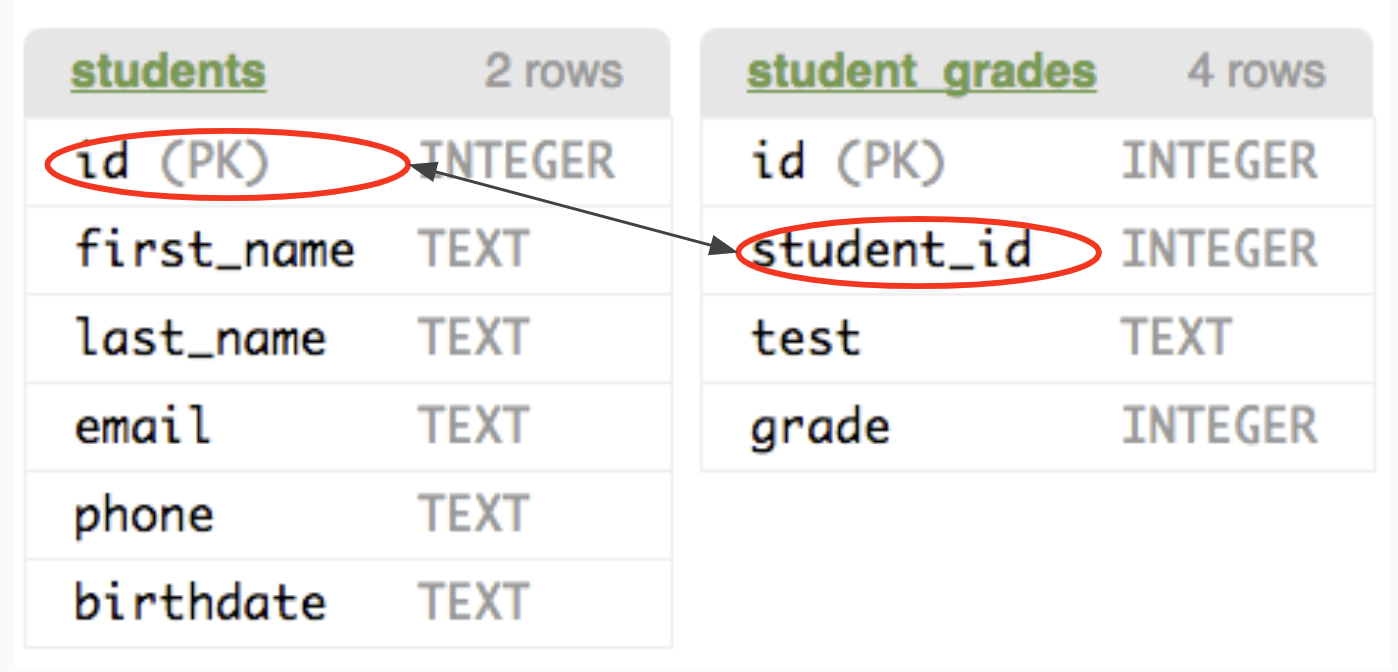</div>

Relaci 1:N bychom pro filmy a herce mohli ale použít jen v příkadě, že by každý herec hrál jen v jednom filmu (nebo naopak kažý film by měl jen jednoho herce).

### N:N

Chceme vyjádřit informaci, že existují nějaké vazby mezi filmy a herci, kde v jednom filmu může hrát více herců, a naopak jeden herec účinkovat ve více filmech. Tomu se říká relace N:N. V databázi to provedeme tak, že vytvoříme tabulku, která obsahuje řádky s id filmu a id herce. 

TODO: nějaký obrázek

## JOIN

TODO: tady bude ukázka JOIN v SQL vs. merge v DataFrame

<div><img src="https://naucse.python.cz/2020/pydata-praha-jaro/pydata/pandas_correlations/static/joins.svg" width=400></div>

## CREATE TABLE

TODO

## INSERT

TODO

TODO: SQL injection a ošetřování vstupu

## UPDATE

TODO

## DELETE

TODO

## Závěr

## Odkazy

https://naucse.python.cz/2019/brno-podzim-2019-ut/beginners/database/
